In [1]:
import random
import math
import os
import pickle
from tqdm import tqdm, trange
import numpy as np

import sklearn
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pdb

In [2]:
import warnings
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [3]:
from pytorch_pretrained_bert import BertTokenizer

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [6]:
data_pkl_path = "../../data/hotpot_context/"
data_pkl_name = "preprocessed_dev_full_length.pkl"
predictions_pkl_path = "./with_para_name/"
predictions_pkl_name = "predictions.pkl"

max_sentences_per_paragraph = 10

In [7]:
def score(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    assert(len(gt) != 0)
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_correct = 0
    num_1_recall = 0
    for i in range(total_size):
        if(gt[i] == pred[i]):
            total_correct += 1
        p = precision_score(gt[i], pred[i],average="binary")
        r = recall_score(gt[i], pred[i],average="binary")
        if(r == 1):
            num_1_recall += 1
        total_precision += p
        total_recall += r
        total_f1 += 2*(p*r)/(p+r) if (p+r)>0 else 0
    return {"precision":total_precision/total_size, "recall":total_recall/total_size, 
            "f1":total_f1/total_size, "em":total_correct/total_size, 
            "full_recall_fraction": num_1_recall/total_size}

def get_em_id(gt, pred):
    assert(len(gt) == len(pred))
    total_size = len(pred)
    assert(len(gt) != 0)
    out_list = []
    for i in range(total_size):
        if(gt[i] == pred[i]):
            out_list.append(i)
    return out_list
    

In [8]:
dataset = unpickler(data_pkl_path, data_pkl_name)

In [9]:
dataset.keys()

dict_keys(['sequence_0', 'sentence_start_index_0', 'sentence_end_index_0', 'supporting_fact_0', 'segment_id_0', 'sequence_1', 'sentence_start_index_1', 'sentence_end_index_1', 'supporting_fact_1', 'segment_id_1', 'sequence_2', 'sentence_start_index_2', 'sentence_end_index_2', 'supporting_fact_2', 'segment_id_2', 'sequence_3', 'sentence_start_index_3', 'sentence_end_index_3', 'supporting_fact_3', 'segment_id_3', 'sequence_4', 'sentence_start_index_4', 'sentence_end_index_4', 'supporting_fact_4', 'segment_id_4', 'sequence_5', 'sentence_start_index_5', 'sentence_end_index_5', 'supporting_fact_5', 'segment_id_5', 'sequence_6', 'sentence_start_index_6', 'sentence_end_index_6', 'supporting_fact_6', 'segment_id_6', 'sequence_7', 'sentence_start_index_7', 'sentence_end_index_7', 'supporting_fact_7', 'segment_id_7', 'sequence_8', 'sentence_start_index_8', 'sentence_end_index_8', 'supporting_fact_8', 'segment_id_8', 'sequence_9', 'sentence_start_index_9', 'sentence_end_index_9', 'supporting_fact

In [10]:
predictions_raw = unpickler(predictions_pkl_path, predictions_pkl_name)

In [11]:
dataset['document_length'][10]

[4, 7, 5, 11, 1, 3, 4, 2, 6, 5]

In [12]:
predictions_raw.shape

(7344, 100)

In [13]:
dataset['supporting_fact_0'][0]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [14]:
predictions_raw[0]

array([ -4.291632 , -11.336963 , -11.273513 , -12.047723 , -12.047723 ,
       -12.047723 , -12.047723 , -12.047723 , -12.047723 , -12.047723 ,
         7.3335133,  -5.855005 ,  -5.449002 , -10.331241 , -10.331241 ,
       -10.331241 , -10.331241 , -10.331241 , -10.331241 , -10.331241 ,
       -11.262955 , -11.455846 , -11.503751 , -11.433736 , -11.306431 ,
       -11.304015 , -11.304015 , -11.304015 , -11.304015 , -11.304015 ,
       -10.005153 , -11.703899 , -11.373544 , -11.449281 , -11.383056 ,
       -11.779988 , -11.779988 , -11.779988 , -11.779988 , -11.779988 ,
         7.551784 ,  -9.4089365,  -9.4089365,  -9.4089365,  -9.4089365,
        -9.4089365,  -9.4089365,  -9.4089365,  -9.4089365,  -9.4089365,
       -11.145469 , -11.534027 , -11.354439 , -11.406756 , -11.406756 ,
       -11.406756 , -11.406756 , -11.406756 , -11.406756 , -11.406756 ,
       -11.35543  , -11.454217 , -11.488702 , -11.449594 , -11.414683 ,
       -11.463858 , -11.463858 , -11.463858 , -11.463858 , -11.4

In [15]:
list(range(0,10,5))

[0, 5]

In [16]:
def reorganize_predictions(predictions, document_lengths):
    out_list = []
    for i, pred in enumerate(predictions):
        num_paragraphs = len(document_lengths[i])
        max_sentences_per_para = 10
        new_pred = []
        for j,num_sentences in enumerate(document_lengths[i]):
            new_pred += pred[j*max_sentences_per_para : j*max_sentences_per_para + min(max_sentences_per_para, num_sentences)]
        out_list.append(new_pred)
    return out_list
        

def stack_suporting_facts(dataset):
    out_list = []
    data_size = len(dataset['supporting_fact_0'])
    for i in range(data_size):
        num_paragraphs = len(dataset['document_length'][i])
        stacked_sf = []
        for j in range(num_paragraphs):
            stacked_sf += dataset['supporting_fact_{}'.format(j)][i]
        out_list.append(stacked_sf)
    return out_list



def reorganize_predictions_old(predictions, document_lengths):
    out_list = []
    start_index = 0
    for i in range(len(document_lengths)):
        pred_raw = predictions[start_index:start_index+len(document_lengths[i])]
        pred = []
        for j,p in enumerate(pred_raw):
            pred += p[:document_lengths[i][j]]
            pred += [0] * (document_lengths[i][j] - len(p[:document_lengths[i][j]]))
        out_list.append(pred)
        start_index += len(document_lengths[i])
    return out_list

In [17]:
predictions_reorganized = reorganize_predictions(predictions_raw.tolist(), dataset['document_length'])

In [18]:
sf_stacked = stack_suporting_facts(dataset)

In [19]:
supporting_facts_reorganized = reorganize_predictions(sf_stacked, dataset['document_length'])

In [20]:
for i in trange(len(predictions_reorganized)):
    assert(len(supporting_facts_reorganized[i]) == len(predictions_reorganized[i]))

100%|██████████| 7344/7344 [00:00<00:00, 905277.39it/s]


In [21]:
def evaluate(gt, pred_raw, threshold, dataset):
    pred_answer_labels = (torch.sigmoid(torch.tensor(pred_raw)) > threshold).numpy().tolist()
    predictions_reorganized = reorganize_predictions(pred_answer_labels, dataset['document_length'])
    result = score(gt, predictions_reorganized)
    return result
    
    

def evaluate_old(gt, pred, threshold, document_lengths):
    pred_answer_labels = (torch.sigmoid(torch.tensor(pred)) > threshold).numpy().tolist()
    predictions_reorganized = reorganize_predictions(pred_answer_labels, document_lengths)
    supporting_facts_reorganized = reorganize_predictions(gt, document_lengths)
    result = score(supporting_facts_reorganized, predictions_reorganized)
    return result

In [22]:
evaluate(supporting_facts_reorganized, predictions_raw, 0.5, dataset)

{'precision': 0.7840169169519793,
 'recall': 0.8790275832555293,
 'f1': 0.8132016706363434,
 'em': 0.40019063180827885,
 'full_recall_fraction': 0.732979302832244}

In [23]:
metrics = {'precision':[], 'recall':[], 'f1':[], 'em':[], 'full_recall_fraction':[]}
for t in tqdm(np.linspace(0.1,1,18,endpoint=False)):
    result = evaluate(supporting_facts_reorganized, predictions_raw, t, dataset)
    for key,value in result.items():
        metrics[key].append(value)

100%|██████████| 18/18 [03:42<00:00, 12.52s/it]


In [24]:
max(metrics['f1'])

0.8180128150716677

In [25]:
max(metrics['em'])

0.48856209150326796

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
metric_df = pd.DataFrame(metrics, index=np.linspace(0.1,1,18,endpoint=False))

In [28]:
metric_df

,precision,recall,f1,em,full_recall_fraction
0.10,0.653573,0.953570,0.754204,0.236111,0.890931
0.15,0.678545,0.943746,0.770176,0.264706,0.868736
0.20,0.698342,0.933913,0.781385,0.285403,0.845724
0.25,0.715348,0.924087,0.789777,0.303377,0.824755
0.30,0.731352,0.915655,0.797140,0.325163,0.807326
0.35,0.746176,0.906004,0.802654,0.343546,0.787446
0.40,0.759251,0.896643,0.806524,0.361383,0.767702
0.45,0.771891,0.888542,0.810611,0.381400,0.751225
0.50,0.784017,0.879028,0.813202,0.400191,0.732979
0.55,0.795058,0.870294,0.815079,0.415577,0.717456


<Figure size 432x288 with 0 Axes>

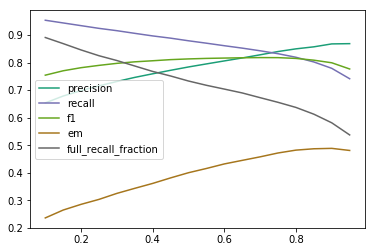

In [29]:
plt.figure(); metric_df.plot(colormap="Dark2");

In [30]:
import seaborn as sns

/home/bhargav/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


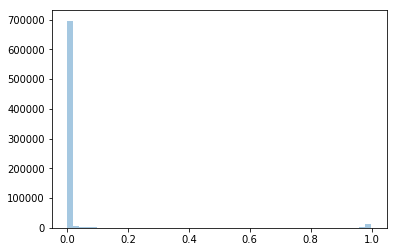

In [31]:
sns.distplot((torch.sigmoid(torch.tensor(predictions_raw))).numpy().flatten(),kde=False, hist=True, rug=False)

# Analysis

In [32]:
# predictions_reorganized = reorganize_predictions(predictions_raw.tolist(), dataset['document_length'])

In [65]:
sf_stacked = stack_suporting_facts(dataset)

In [66]:
supporting_facts_reorganized = reorganize_predictions(sf_stacked, dataset['document_length'])

In [67]:
threshold = 0.7

In [68]:
pred_answer_labels = (torch.sigmoid(torch.tensor(predictions_raw)) > threshold).numpy().tolist()
predictions_ans_label_reorganized = reorganize_predictions(pred_answer_labels, dataset['document_length'])
pred_raw_reorganized = reorganize_predictions(torch.sigmoid(torch.tensor(predictions_raw)).numpy().tolist(),
                                              dataset['document_length'])

In [69]:
questions_em = get_em_id(supporting_facts_reorganized, predictions_ans_label_reorganized)

In [70]:
len(questions_em)/len(predictions_ans_label_reorganized)

0.45778867102396514

In [71]:
print(questions_em[:50])

[0, 3, 5, 6, 7, 9, 10, 11, 15, 17, 19, 24, 25, 27, 30, 32, 35, 37, 38, 39, 45, 46, 47, 49, 54, 55, 57, 58, 61, 70, 73, 77, 78, 79, 80, 82, 83, 84, 86, 87, 88, 89, 90, 92, 95, 96, 98, 101, 102, 105]


In [89]:
def organize_predictions_into_sentences(predictions, document_lengths):
    out_list = []
    for i, pred in enumerate(predictions):
        sentences = []
        start_index = 0
        for j,num_sentences in enumerate(document_lengths[i]):
            sentences.append(pred[start_index:start_index+min(num_sentences,10)])
            start_index += min(num_sentences,10)
        out_list.append(sentences)
    return out_list

In [90]:
sum(dataset['document_length'][15])

66

In [91]:
dataset['document_length'][100]

[3, 11, 2, 5, 1, 2, 5, 5, 4, 5]

In [92]:
len(supporting_facts_reorganized[15])

65

In [93]:
supporting_facts_reorganized[15][-5:]

[0, 0, 1, 0, 0]

In [94]:
len(pred_raw_reorganized[15])

65

In [95]:
pred_raw_sentence_wise = organize_predictions_into_sentences(pred_raw_reorganized, dataset['document_length'])

In [96]:
[len(i) for i in pred_raw_sentence_wise[100]]

[3, 10, 2, 5, 1, 2, 5, 5, 4, 5]

In [97]:
predictions_ans_label_reorganized[15] == supporting_facts_reorganized[15]

True

In [99]:
index_of_interest = 15
sequence_of_interest = tokenizer.convert_ids_to_tokens(dataset["sequence_9"][index_of_interest])
print(sequence_of_interest[:50])
for i, probs in enumerate(pred_raw_sentence_wise[index_of_interest]):
    print("Paragraph: {}, Probabilities:{}".format(i, probs))
    print("--------------------------------------------------------")

['[CLS]', 'brown', 'state', 'fishing', 'lake', 'is', 'in', 'a', 'country', 'that', 'has', 'a', 'population', 'of', 'how', 'many', 'inhabitants', '?', '[SEP]', 'brown', 'county', ',', 'kansas', '.', 'brown', 'county', '(', 'county', 'code', 'br', ')', 'is', 'a', 'county', 'located', 'in', 'the', 'northeast', 'portion', 'of', 'the', 'u', '.', 's', '.', 'state', 'of', 'kansas', '.', 'as']
Paragraph: 0, Probabilities:[0.0012515384005382657, 1.878989496617578e-05, 1.0847497833310626e-05, 1.3416929505183361e-05, 2.383126411587e-05]
--------------------------------------------------------
Paragraph: 1, Probabilities:[0.06025658920407295, 0.0007650629850104451, 0.002429602900519967, 0.00022336610709317029, 0.0002499705005902797, 0.0003645961405709386]
--------------------------------------------------------
Paragraph: 2, Probabilities:[0.9991253018379211, 0.014514945447444916, 0.022710369899868965]
--------------------------------------------------------
Paragraph: 3, Probabilities:[0.00022556